# Machine Learning #2 - Korelasyon Matrisi, Özellik Seçimi, Sınıfların Dengesizliği, Karar Ağaçları, Kesinlik/Duyarlılık/F1 Skoru

Merhabalar, Machine Learning serimin ikinci notebook'unda 
- Yeni bir sınıflandırma modelini kullanacak
- Tahminleyici değişkenlerin hedef değişken ile aralarındaki ilişkiyi inceleyecek
- Veri önişlemesi kısmında yeni yöntemler görecek
- Modelimizin başarımını ölçmek için kullanabileceğimiz yeni yöntemlere değineceğiz.

Aynı zamanda veri kümesi dengesizliklerine, model başarımını değerlendirirken yapabileceğimiz hatalara ve bunları gidermek için yapılabileceklere değineceğimiz bir yazı olacak.

Temel kütüphanelerimizi ***import*** ederek başlıyoruz.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('winequality-red.csv')

Bu yazıda, şarap örneklerinin kalitelerini, kimyasal değerlerine göre tahmin etmeye çalışan bir şarap tadımcısı modeli geliştireceğiz. Veri kümesini, ilk yazıda da faydalandığımız kaynaktan edindim. https://archive.ics.uci.edu/ml/datasets/wine+quality adresinden ulaşabilirsiniz.

Serinin ilk yazısında değindiğimiz metodlara tekrar ayrıntılı olarak değinmeyeceğiz. İlk olarak Keşifsel Veri Analizi kısmıyla başlıyoruz. Bu bölüm ile ilgili bilgiyi bu repodaki **ml01 notebook'unu** inceleyerek edinebilirsiniz.

## Nümerik EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Veri kümemiz 1599 satır ve 12 sütundan oluşuyor. İlk 11 özelliği öğrenerek, ***quality*** özelliğini tahmin etmeye çalışacağız.

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Burada, özellik değerlerimize dair birtakım özetler görüyoruz. Her bir sütunun ***mean***, ***max***, ***std*** ve ***min*** değerlerinin yanı sıra, %25, %50 ve %75 gibi ifadelerimiz var.
- Min ve max, o sütundaki en küçük ve en büyük sayı değerlerini,
- mean değeri sütun değerlerinin ortalamasını, std standart sapma değerini
- %25, %50 ve %75 değerleri de sütundaki değerlerin yüzde kaçının o değere eşit veya altında olduğunu gösterir.

Tablodaki ***quality*** sütununu incelediğimizde, değerlerin 3 ve 8 arasında değiştiğini görüyoruz(min değeri 3, max değeri 8). Ve, bu sütundaki verilerin dörtte biri 5 ve altında(3, 4, 5) iken, dörtte üçü de 6 ve altında (3, 4, 5, 6). Ortalama değerimiz de **5.63**. 

**Bu değerler bize veri kümemizdeki** ***__quality__*** **değerlerinin çoğunun ortalama değerlere(5 ve 6 gibi) sahip olduğunu, dağılımın dengesiz olduğunu göstermektedir.**

***Problem***: Bu dengesizlik, modelimizin orta kalite şarabı iyi ayırt edebilmesine, ancak düşük kaliteli veya yüksek kaliteli şarabı ayırt edememesine sebep olacaktır. **Sınıfların Dengesizliği(Class Imbalanced) adı verilen bu probleme, ilgili başlıkta bir çözüm geliştirmeye çalışacağız.**

In [5]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


Veri kümemizin ilk 10 satırının sütun değerlerini görmekteyiz. ***volatile acidity***, ***citric acid*** gibi değerlerin 0'a oldukça yakınken, ***free sulfur dioxide***, ***total sulfur dioxide*** değerlerinin ise genellikle 0'dan çok büyük olduğunu görmekteyiz.

İlk yazıda değindiğimiz **kNN** gibi sınıflandırıcıların, uzaklık hesabı yaparak çalıştığını hatırlayın. Bu durumda, sayısal olarak büyük değerler analitik düzlemin dış köşelerinde konumlanacak, uzaklık hesabında çıkan büyük değerlerden dolayı modelimiz yanlış tahminler yapabilecektir. Bu durumun da çözümüne değineceğiz.

## Özellik Seçimi & Korelasyon Matrisi

İnceleyeceğimiz diğer bir durum da, tahminleyici değişkenlerimizin arasındaki artış/azalış ilişkisidir. Özellik seçimi, herhangi bir makine öğrenimi problemini çözerken gerçekleştirilen ilk ve önemli adımlardan biridir. Veri kümemizdeki her bir özellik, basitçe bir sütunla temsil edilir. Her sütunun (özelliğin) hedef değişkeni üzerindeki etkisi aynı olmayabilir.

Hedef değişkenle arasındaki ilişkinin zayıf olduğu bir tahminleyici değişkeni modele eklemek performans üzerine bazı olumsuz etkileri vardır. Daha fazla tahminleyici değişken, training süresinin daha uzun olmasına, hesaplama karmaşıklığının artmasına ve bazı önemli olabilecek özelliklerin etkisinin azalmasına sebep olur.

Bu durum, **özellik seçimi** yapma ihtiyacını doğurur.

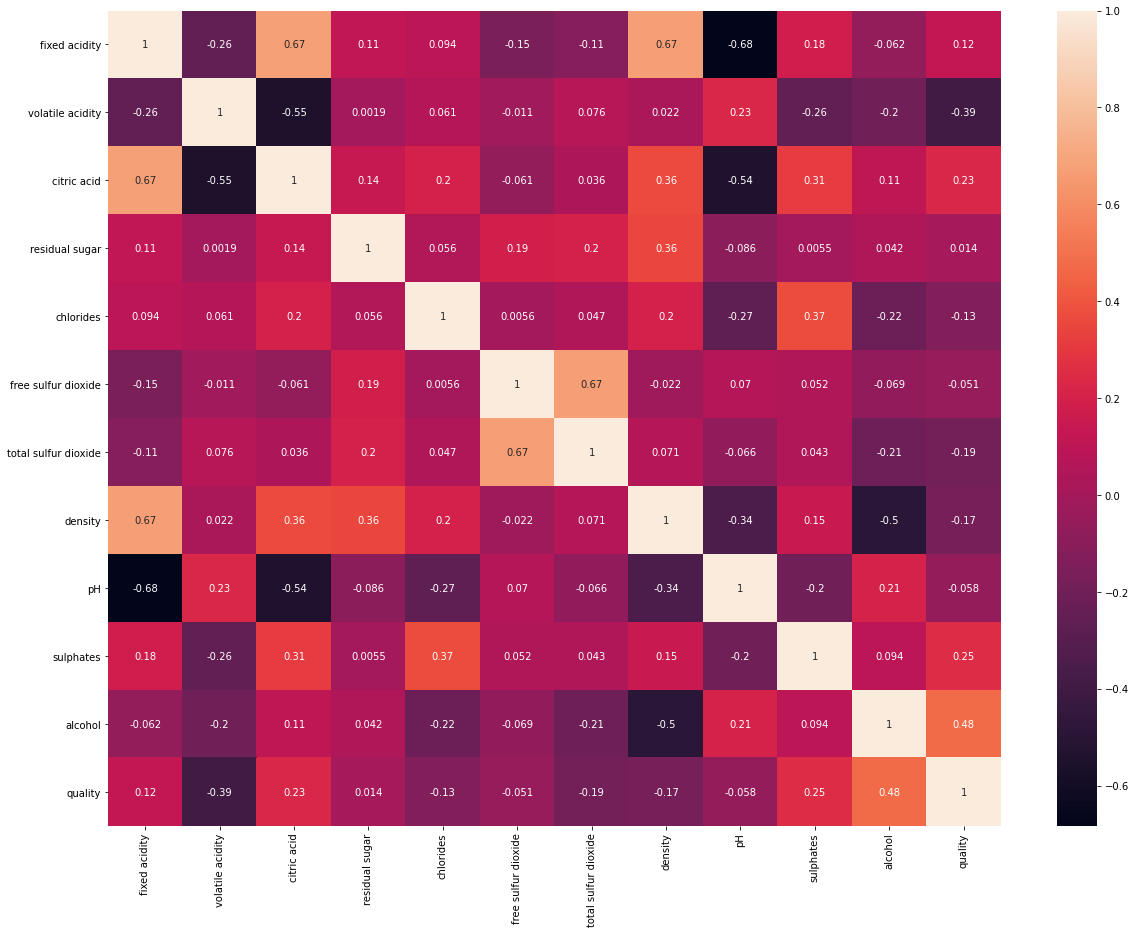

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

***seaborn*** kütüphanesini kullanarak bir **korelasyon matrisi** oluşturduk. Bu matris, bütün özelliklerin birbirleri ile aralarındaki ilişkiyi bir renk paletinde bize gösterir. 

**Korelasyon matrisi**nde değerler, -1 ile +1 arasında konumlanır. -1' e yakın değerler **negatif korelasyon**, +1'e yakın değerler **pozitif korelasyon** olarak yorumlanır. 

**Pozitif korelasyon**a sahip iki değişkenin değerleri birlikte artar veya birlikte azalır.

**Negatif korelasyon**a sahip iki değişkenlerden birinin değeri artarken diğerininki azalır.

Değerin 0'a yakın olması durumu ise bu iki değişken arasında bir bağlantı olmadığını gösterir. Hedefimiz ***quality*** özelliği ile arasındaki korelasyon değeri 0'a yakın olan özellikleri bulup bunları elemektir.

In [7]:
cor_target = abs(corr_matrix["quality"])
relevant_features = cor_target[cor_target>0.1]
relevant_features

fixed acidity           0.124052
volatile acidity        0.390558
citric acid             0.226373
chlorides               0.128907
total sulfur dioxide    0.185100
density                 0.174919
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

***quality*** özelliği ile arasındaki korelasyon değeri **-0.1** ile **+0.1** arasında olan özellikleri ***relevant_features*** ismiyle oluşturduğumuz değişkene atadık. Bu değişkenlerden biri normal olarak korelasyon değeri **1** olan ***quality*** değişkenimiz. Geriye kalan **8** değişkeni tahminleyici olarak kullanacağız.

In [8]:
to_drop = cor_target[cor_target<0.1]
to_drop

residual sugar         0.013732
free sulfur dioxide    0.050656
pH                     0.057731
Name: quality, dtype: float64

***residual sugar***, ***free sulfur dioxide*** ve ***pH*** değişkenleri de, düşük korelasyon tespit ettiğimiz ve kullanmayacağımız özellikler. Bunları da ***to_drop*** değişkeninde topladık.

***to_drop*** değişkenini incelediğimizde bize **Name** ve **dtype** adında iki bilgi daha dönüyor. Yani bu değişken şu anda bildiğimiz Python listesi değil. Ancak training kümemizden düşürebilmek için liste olarak vermeliyiz. ***type()*** komutuyla veri tipini öğrenelim.

In [9]:
type(to_drop)

pandas.core.series.Series

Veri tipini öncelike bir diğer pandas veri tipi olan **frame**'e çeviriyoruz.

In [10]:
to_drop_frame = to_drop.to_frame()
to_drop_frame

,quality
residual sugar,0.013732
free sulfur dioxide,0.050656
pH,0.057731


Son olarak, bu değişkenleri bir listeye çevirip, ***quality*** değişkenini de ekleyerek düşüreceğimiz değişkenler listesini son haline getiriyoruz.

In [11]:
row_names = to_drop_frame.index
row_names_list = list(row_names)
row_names_list.append('quality')
print(row_names_list)

['residual sugar', 'free sulfur dioxide', 'pH', 'quality']


In [12]:
y = df['quality'].values
X = df.drop(row_names_list, axis=1).values

## Sınıfların Dengesizliği

Tahminleyici ve hedef değişkenlerimizi belirleyerek ***X*** ve ***y*** değişkenlerine atadıktan sonra bu bölümle ilgili yapacağımız son bir işlem daha kaldı. ***df.describe()***'ın bize gösterdiği üzere, ***quality*** özelliğimiz **3**, **4**, **5**, **6**, **7** ve **8** değerlerini alıyor. Test kümesi için, toplam kümedeki 1599 verinin yaklaşık **5**'te **1**'ini ayıracağımızı düşünürsek, yaklaşık 320 örneği 6 farklı sınıfa ayırmasını bekliyor olacağız. Bu durum, modelimizin başarımını düşürebilir.

***df.describe()*** kısmında değindiğimiz üzere, elimizdeki örnekler genellikle orta kaliteden oluşmakta. Bundan dolayı, yüksek ve düşük kalite şarapları da tanıyabilmesi için 
Senaryo olarak, **3** ve **4** puanlı şarapların **düşük**, **5** ve **6** puanlı şarapların **orta**, **7** ve **8** puanlı şarapların da **yüksek** kaliteli şaraplar olduğunu düşünerek, modelimizin öğrenmesi gereken sınıf sayısını **6**'dan **3**'e düşürelim.

In [13]:
y = [0 if value == 3 or value == 4 else 1 if value == 5 or value == 6 else 2 for value in y]

Elimizdeki veri kümesinin daha büyük olması durumunda daha efektif,literatürde yeri olan, algoritmik çözümler de geliştirmek mümkündür.

**Bu çözümlere dair bir ileri okuma olarak**: https://medium.com/quantyca/how-to-handle-class-imbalance-problem-9ee3062f2499

## Karar Ağaçları

Bir karar ağacı, veri kümesini bir dizi karar kuralları uygulayarak daha küçük kümelere bölmek için kullanılan bir yapıdır.

**Karar ağacı**, istatistik, veri madenciliği ve makine öğreniminde kullanılan tahmine dayalı modelleme yaklaşımlarından biridir. Bir öğe hakkındaki gözlemlerden (dallarda temsil edilen tahminleyici değişkenler) öğenin hedef değeri (yapraklarda temsil edilen hedef değişken) ile ilgili sonuçlara gitmek için bir karar ağacı (tahminleyici model) kullanır. Hedef değişkenin ayrı bir değer kümesi alabildiği ağaç modellerine sınıflandırma ağaçları denir; bu ağaç yapılarında, yapraklar sınıf etiketlerini temsil eder ve dallar, bu sınıf etiketlerine götüren özelliklerin birleşimlerini temsil eder.

![title](1.png)

Karar ağaçlarında en üstte yer alan noktalara **kök** denir. Her bir gözlem kökteki koşula göre sınıflandırılır.

Kök hücrelerinin altında **düğümler** bulunur. Her bir gözlem düğümler yardımıyla sınıflandırılır. Düğüm sayısı arttıkça modelin karmaşıklığı da artar.

Karar ağacının en altında **yapraklar** bulunur. Yapraklar, bize sonucu verir.

**Pipeline** oluştururken, **grid search** için iki parametre kullanacağız, ***scikit-learn***'in ***DecisionTreeClassifier***'ına ait ***criterion*** ve ***max_depth*** parametreleri. Basitçe, modelimiz veriyi dallara ayırırken hangi bilgi kriterini kullanacak, ve en fazla kaç adımda bilgiyi optimize edecek sorularının cevaplarını arayacağız.

Bu ve diğer tüm karar ağacı parametrelerine dair detaylı bilgi için; https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html dokümanını inceleyip, bu notebook'taki örneği, farklı parametreler, farkı değerler için deneyebilirsiniz.

Karar ağacımızı kodlamaya başlamadan önce, modelimiz için yapacağımız son bir iyilik daha var.

## Normalizasyon (Merkezileştirme veya Ölçekleme)

Yazının giriş kısmında, tahminleyici değişkenlerimizden bazılarının değerlerinin **0**'a oldukça yakın, bazılarının da **0**'dan oldukça büyük olduğundan söz etmiştik. Bu durum, büyük değerlere sahip değişkenlerin modeli daha fazla(olumsuz yönde) etkilemesine sebep olur. Bütün tahminleyici değişkenlerimizi, birbirleriyle benzer ölçülerde temsil etmek isteriz.

Bunun için, ***scikit-learn***'in ***StandardScaler*** metodunu kullanacağız.

Sırada, tanımladığımız bütün bu önişleme süreçlerini kodlamak var.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [15]:
steps = [('scaler', StandardScaler()),
('dec_tree', DecisionTreeClassifier())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [16]:
params = {"dec_tree__criterion":['gini', 'entropy'],
         "dec_tree__max_depth":np.arange(3, 15)
         }

Bu adımda, **gini** ve **entropy** kavramlarından da kısaca bahsedecek olursak,

**Gini(veya Gini Safsızlığı)**: Veri kümesindeki rastgele seçilen bir öğeyi yanlış bir şekilde sınıflandırma olasılığıdır. 

**Entropi**: Bir değişkenin entropisi, değişkenin olası sonuçlarının doğasında bulunan ortalama "bilgi", "sürpriz" veya "belirsizlik" seviyesidir. Karar ağacının kök kısmında sınıflandırma, entropi miktarı en az olan özellikten başlar.

Entropi kavramını bir örnekle anlatacak olursak, havanın güneşli mi yağmurlu mu olduğu bilgisinin entropisi, sinemada gösterimde olan filmlerin bilgisinin entropisine göre daha düşüktür. Bunun anlamı, günü nasıl geçireceğinize dair karar verirken, hava durumundan başlamanızın daha olası olduğudur. Eğer hava yağmurluysa, sinemaya gitmek yerine evde oturmayı tercih edersiniz, böylece sinemada hangi filmlerin olduğunu düşünmenize de gerek kalmaz.

Entropi ve bilgi teorisi kavramlarına dair ileri okumalar için: https://en.wikipedia.org/wiki/Entropy_(information_theory)

In [17]:
from sklearn.model_selection import GridSearchCV
for cv in range(3,10):
    cv_grid = GridSearchCV(pipeline, param_grid=params,cv=cv)
    cv_grid.fit(X_train, y_train)
    print("%d fold score: %3.2f" %(cv,cv_grid.score(X_test, y_test)))
    print("Best parameters: ", cv_grid.best_params_)

3 fold score: 0.86
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 4}
4 fold score: 0.86
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 4}
5 fold score: 0.84
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 5}
6 fold score: 0.83
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 9}
7 fold score: 0.83
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 9}
8 fold score: 0.84
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 7}
9 fold score: 0.85
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 7}


İlk yazıda değindiğimiz **Grid Search** tekniğini kullanarak, en iyi kriterimizin ***gini***, en uygun derinliğimizin de ***4*** olduğu sonucuna vardık. Bu kriterleri kullandığımızda, modelimizin **%86** başarıma ulaştığını gördük. Peki gerçekten de modelimiz bu kadar iyi mi çalışıyor?

## Kesinlik/Duyarlılık/F1 Skoru

Özellikle de eşit dağılmayan veri kümelerinde modelin **doğruluğu(accuracy)** tek başına yeterli değildir. Modelimizin başarımını tam olarak ölçmek için, bazı farklı metriklerden yararlanmak gerekir. 

Bunun için öncelikle **Karışıklık Matrisi** kavramına değinelim.

![title](2.png)

**True Positive** ve **True Negative** doğru tahminlerimizi, **False Positive** ve **False Negative** ise yanlış tahminlerimizi içeren alanlardır. Örnek olarak görevimizin elimizdeki bir mail kümesindeki spam mailleri belirlemek olduğunu düşünelim.

- True Positive : Modelimiz maili spam olarak tahmin etti ve bu doğru.
- True Negative: Modelimiz maili spam değil olarak tahmin etti ve bu doğru.
- False Positive : Modelimiz maili spam olarak tahmin etti ve bu yanlış.
- False Negative: Modelimiz maili spam değil olarak tahmin etti ve bu yanlış.

![title](accuracy.png)

Modelin **doğruluğu(accuracy)**, **True** tahminlerin toplam sayıya bölümüyle bulunur. **100** kişilik bir insan topluluğunda **10** kanser hastası, **90** sağlıklı insan olduğunu düşünelim. Modelimiz, bu grubun tamamının sağlıklı olduğunu tahmin ederse, **%90** oranında başarıya ulaşır. Ancak aynı zamanda o **10** hastayı da sağlıklı olarak tahmin ettiği için, başarılı olduğu kadar ölümcül de bir model olur. 

Bu nedenle, modelin başarımını ölçmek için farklı metriklere ihtiyacımız vardır.

![title](precision.png)

**Kesinlik(Precision)**, **Positive** olarak tahminlediğimiz değerlerin gerçekten kaçının **Positive** olduğunun oranını verir.

**Kesinlik**, **False Positive** tahminlerin maliyetinin yüksek olduğu durumlarda çok önemlidir. Örneğin Gelen Kutusu'na düşmesi gereken mailleriniz modelinizin hatalı tahmini sonucu Spam Kutusu'na düşerse bu durumda görmeniz gereken önemli mailleri görememiş olur ve kayıp yaratan bir durumda kalırsınız. Bu durumda **Kesinlik** değerinin yüksek olması modelin başarımını değerlendirmede önemli bir kriterdir.

![title](recall.png)

**Duyarlılık (Recall)** ise, **Positive** olarak tahmin etmemiz gereken örneklerin ne kadarını **Positive** olarak tahmin ettiğimizi gösterir. Mail örneği konusunda, Spam olarak yakalamamız gereken maillerin bir bölümünün Gelen Kutusu'na düşmesi zararsız görünebilir, ancak **Recall** skorunun yüksek olması özellikle Sağlık ve Bankacılık konusundaki veri kümelerinde hayati bir öneme sahip olabilir.

![title](f1score.png)

**F1 Score** değeri bize **Kesinlik** ve **Duyarlılık** değerlerinin harmonik ortalamasını göstermektedir. Eşit dağılmayan veri kümelerinde hatalı bir model seçimi yapmamak ve tüm hata maliyetlerini de içerecek bir ölçme metriğine sahip olmak amacıyla **F1 Score** kullanılır.

Şimdi, elde ettiğimiz en iyi parametrelerle birlikte, karar ağacımızı ***best_tree*** isimli bir değişkene atayarak, eğitim/tahmin sürecini tekrar çalıştıralım ve öğrendiğimiz başarım metrikleri üzerinden model performansını inceleyelim.

In [18]:
best_tree = DecisionTreeClassifier(criterion='gini', max_depth=4)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.88      0.96      0.92       258
           2       0.74      0.62      0.67        45

    accuracy                           0.86       320
   macro avg       0.54      0.53      0.53       320
weighted avg       0.81      0.86      0.84       320



/Users/goker/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Modelimizin düşük kaliteli şaraplardan hiçbirini (17 örnek) tanıyamadığını görüyoruz. Dolayısıyla, **accuracy** değerinin birkaç puan daha az, ama düşük kaliteli şarapları da tanıyan bir modelimizin olması daha doğru olabilir.

Bu örneklerin ayırt edilememesinin bir sebebi, yeteri kadar önekle eğitilmemiş olması olabilir. Dolayısıyla bir sonraki adımda, ***test_size***'ımızı küçülterek eğitim sürecini tekrar başlatalım. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)
params = {"dec_tree__criterion":['gini', 'entropy'],
         "dec_tree__max_depth":np.arange(3, 15)
         }
from sklearn.model_selection import GridSearchCV
for cv in range(3,6):
    cv_grid = GridSearchCV(pipeline, param_grid=params,cv=cv)
    cv_grid.fit(X_train, y_train)
    print("%d fold score: %3.2f" %(cv,cv_grid.score(X_test, y_test)))
    print("Best parameters: ", cv_grid.best_params_)

3 fold score: 0.82
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 6}
4 fold score: 0.78
Best parameters:  {'dec_tree__criterion': 'entropy', 'dec_tree__max_depth': 6}
5 fold score: 0.81
Best parameters:  {'dec_tree__criterion': 'gini', 'dec_tree__max_depth': 4}


Yeni modelimizi, en iyi parametreleriyle tekrar ***best_tree*** değişkenine atayıp, başarı metriklerimizi tekrar inceleyelim.

In [22]:
best_tree = DecisionTreeClassifier(criterion='gini', max_depth=6)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.85      0.93      0.89       126
           2       0.58      0.46      0.51        24

    accuracy                           0.82       160
   macro avg       0.73      0.56      0.61       160
weighted avg       0.81      0.82      0.80       160



Bu kez, düşük kaliteli olarak işaretlediği şarapların **%75**'inin(**precision**) gerçekten de düşük kaliteli olduğunu, ve düşük kaliteli olan şarapların da **%30**'unu(**recall**) doğru tahmin edebildiğini görüyoruz.

Bir önceki denemede, **17** örnekten hiçbirini doğru tahmin edemezken, bu kez **10** örnek olduğu halde düşük kaliteli şarap sınıfında başarımın yükseldiğini görüyoruz. 

Eğitim kümemizde, daha fazla **0** ile etiketlenmiş örnek olduğu için, test kümemizde kalan düşük kaliteli şarapların tahmin skorunu artırabildik.

Bu veri kümemizdeki gibi (ama etkisini görebilmek için daha büyük veri kümelerinde uygulanabilecek) dengesizlik problemlerini çözmek için, **Rastgele Örnekleme(Random Sampling)** tekniğini de inceleyebilirsiniz. Bu tekniği uygulamak için, temelde iki yol vardır:

- **Oversampling**, azınlıkta kalan sınıfların örneklerini çoğaltarak
- **Undersampling**, çoğunlukta kalan sınıfların örneklerini azaltarak

Daha dengeli sınıflar elde edebilirsiniz.

**Python** dilinde bu problem için geliştirilmiş bir kütüphane vardır. https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/index.html#examples-based-on-real-world-datasets linkinde örnekleriyle birlikte bu kütüphaneyi inceleyebilir,

Bu yaklaşıma dair ayrıntılı bir okuma için de https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf linkindeki çalışmayı inceleyebilirsiniz.

Son olarak, ***scikit-learn*** kütüphanesinin ***tree*** metoduyla birlikte karar ağacımızın şeklini çizdirerek, yazımızı noktalıyoruz. Sonraki yazılarda görüşmek üzere.

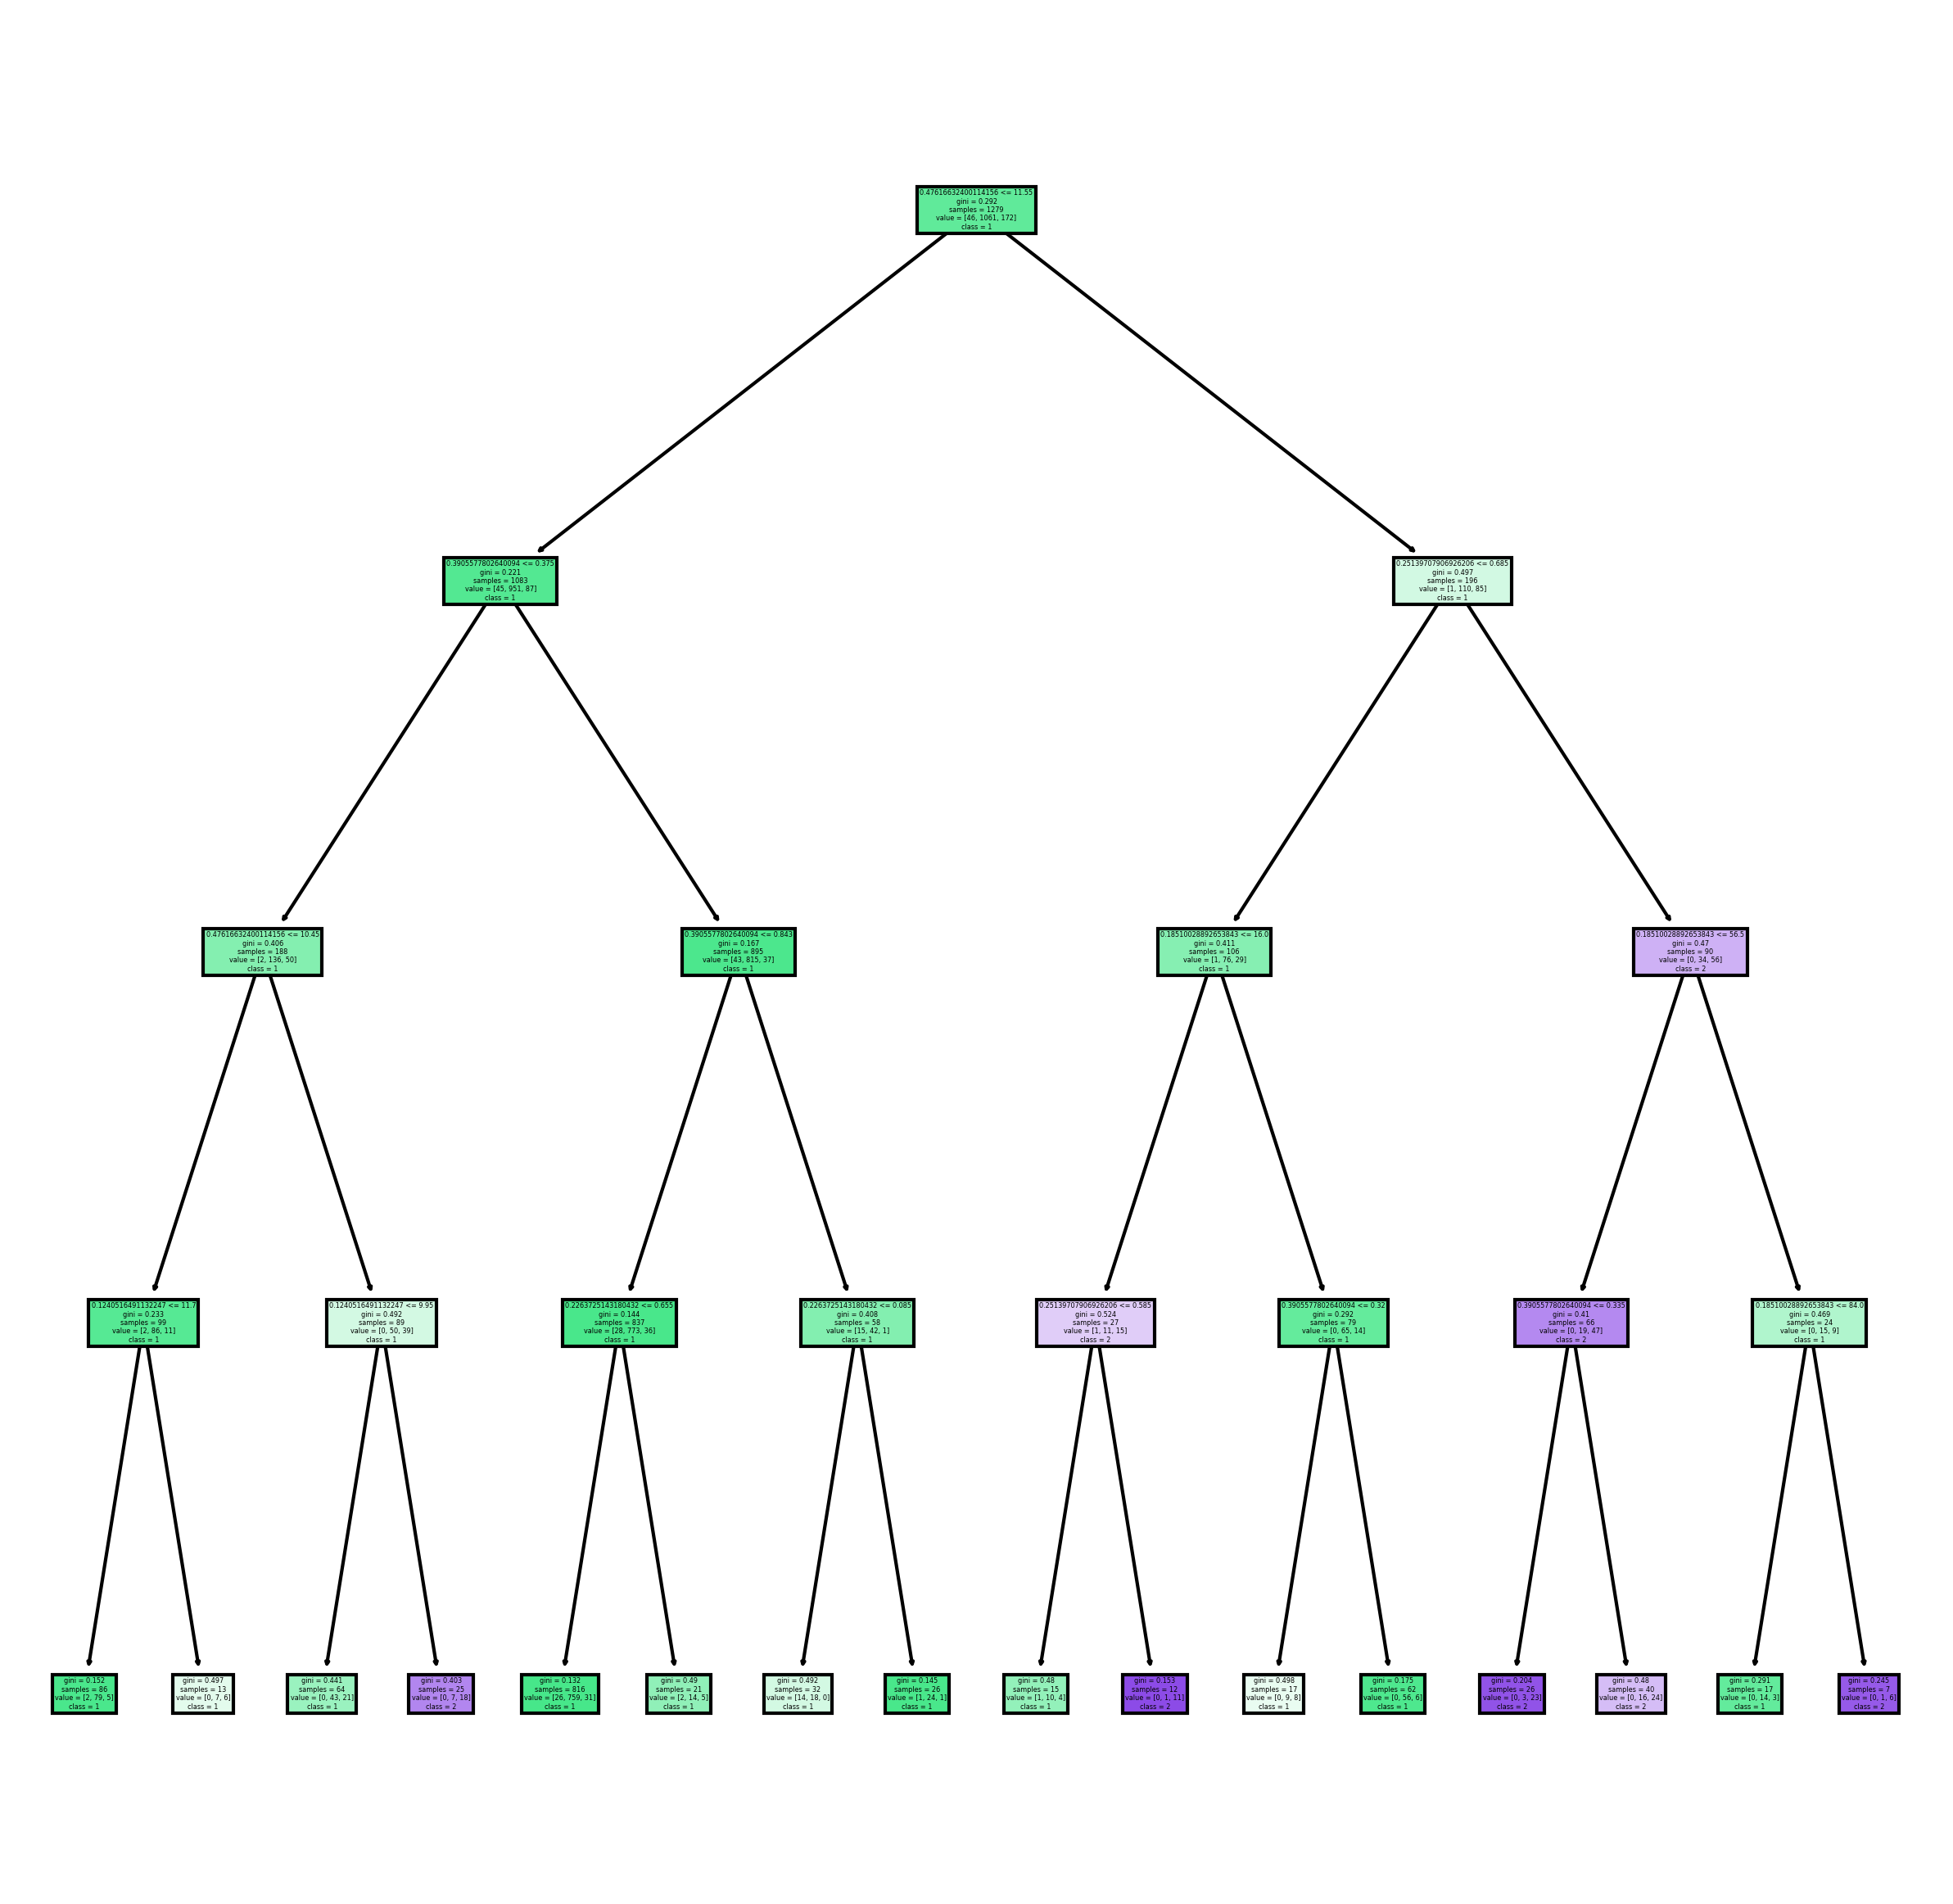

In [20]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(best_tree,
               feature_names = relevant_features[:-1], 
               class_names=["0", "1", "2"],
               filled = True);
fig.savefig('dec_tree.png')